# Clustering and Patient Segmentation

## Overview
Discover patient subgroups through:
- K-Means clustering
- Hierarchical clustering
- DBSCAN
- Cluster profiling
- Actionable insights

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('output/processed_data.csv')
exclude_columns = ['ID', 'admission_date', 'discharge_date', 'admission_time', 'discharge_time', 'disease_status']
X = data[[col for col in data.columns if col not in exclude_columns]].select_dtypes(include=[np.number]).fillna(0)
y = data['disease_status']
print(f'Data loaded: {X.shape}')

Data loaded: (2000, 35)


## Data Standardization

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f'Data standardized: {X_scaled.shape}')

Data standardized: (2000, 35)


## Elbow Method for Optimal Clusters

Finding optimal number of clusters...
k=2: Silhouette=0.204
k=3: Silhouette=0.147
k=4: Silhouette=0.093
k=5: Silhouette=0.110
k=6: Silhouette=0.117
k=7: Silhouette=0.125
k=8: Silhouette=0.140
k=9: Silhouette=0.129
k=10: Silhouette=0.137


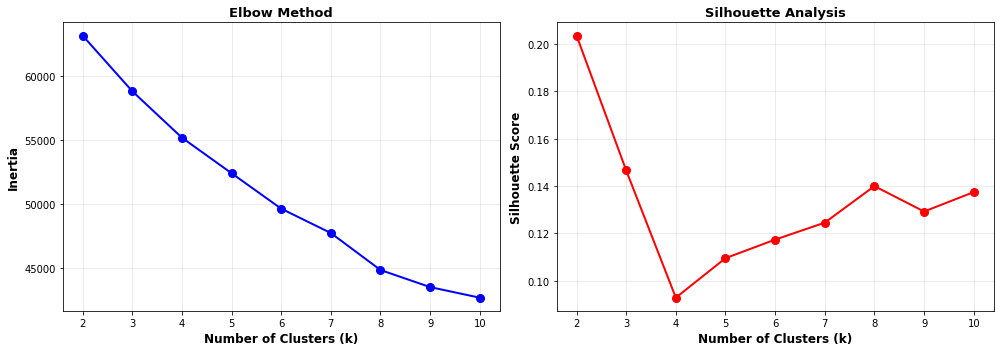


Optimal number of clusters: 2


In [4]:
inertias = []
silhouette_scores = []
K_range = range(2, 11)

print('Finding optimal number of clusters...')
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    print(f'k={k}: Silhouette={silhouette_scores[-1]:.3f}')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Analysis', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f'\nOptimal number of clusters: {optimal_k}')

## K-Means Clustering

In [5]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
clusters = kmeans_final.fit_predict(X_scaled)

data['Cluster'] = clusters

print(f'Clustering complete with k={optimal_k}')
print(f'\nCluster sizes:')
print(data['Cluster'].value_counts().sort_index())

silhouette = silhouette_score(X_scaled, clusters)
davies_bouldin = davies_bouldin_score(X_scaled, clusters)
calinski_harabasz = calinski_harabasz_score(X_scaled, clusters)

print(f'\nClustering metrics:')
print(f'  Silhouette Score: {silhouette:.4f}')
print(f'  Davies-Bouldin Index: {davies_bouldin:.4f} (lower is better)')
print(f'  Calinski-Harabasz Score: {calinski_harabasz:.4f} (higher is better)')

Clustering complete with k=2

Cluster sizes:
Cluster
0    1733
1     267
Name: count, dtype: int64

Clustering metrics:
  Silhouette Score: 0.2036
  Davies-Bouldin Index: 2.0891 (lower is better)
  Calinski-Harabasz Score: 215.3754 (higher is better)


## Visualize Clusters (PCA)

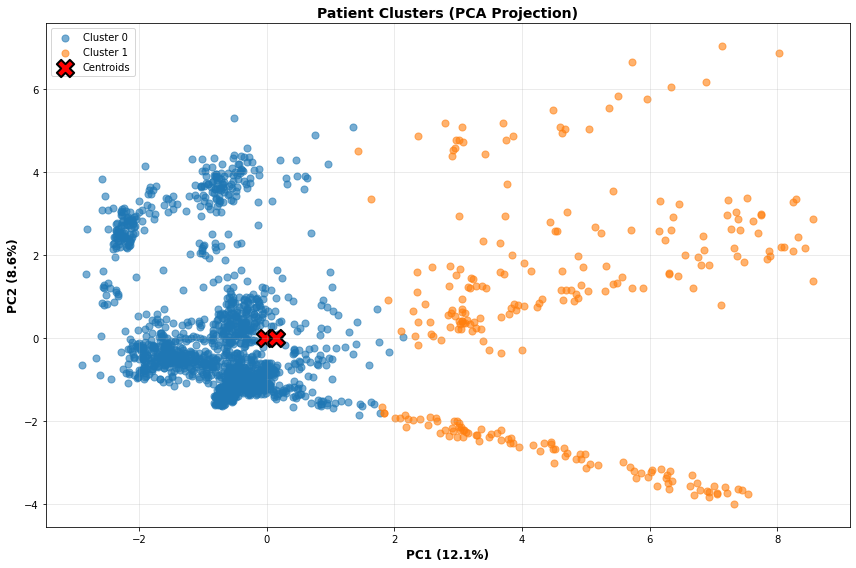

In [6]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
for cluster in range(optimal_k):
    cluster_points = X_pca[clusters == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                label=f'Cluster {cluster}', alpha=0.6, s=50)

plt.scatter(kmeans_final.cluster_centers_[:, 0], kmeans_final.cluster_centers_[:, 1],
            c='red', marker='X', s=300, edgecolors='black', linewidths=2, label='Centroids')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12, fontweight='bold')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12, fontweight='bold')
plt.title('Patient Clusters (PCA Projection)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Cluster Profiling

In [7]:
cluster_profiles = data.groupby('Cluster').agg({
    'age': ['mean', 'std'],
    'length_of_stay': ['mean', 'std'],
    'disease_status': 'mean'
})

print('='*80)
print('CLUSTER PROFILES')
print('='*80)
print(cluster_profiles)

for cluster in range(optimal_k):
    cluster_data = data[data['Cluster'] == cluster]
    disease_rate = cluster_data['disease_status'].mean() * 100
    print(f'\nCluster {cluster}:')
    print(f'  Size: {len(cluster_data)} patients ({len(cluster_data)/len(data)*100:.1f}%)')
    print(f'  Disease rate: {disease_rate:.1f}%')
    print(f'  Avg age: {cluster_data["age"].mean():.1f}')
    print(f'  Avg length of stay: {cluster_data["length_of_stay"].mean():.1f} days')

CLUSTER PROFILES
               age            length_of_stay            disease_status
              mean        std           mean        std           mean
Cluster                                                               
0        58.869590  12.695595      99.401039  56.481058       0.484709
1        60.910112  12.514930      99.127341  60.129549       0.501873

Cluster 0:
  Size: 1733 patients (86.7%)
  Disease rate: 48.5%
  Avg age: 58.9
  Avg length of stay: 99.4 days

Cluster 1:
  Size: 267 patients (13.4%)
  Disease rate: 50.2%
  Avg age: 60.9
  Avg length of stay: 99.1 days


## Disease Rate by Cluster

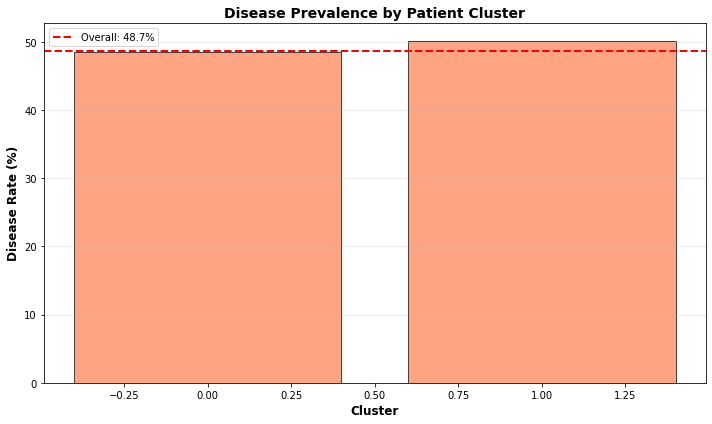

In [8]:
disease_by_cluster = data.groupby('Cluster')['disease_status'].agg(['mean', 'count'])
disease_by_cluster['disease_rate_pct'] = disease_by_cluster['mean'] * 100

plt.figure(figsize=(10, 6))
plt.bar(disease_by_cluster.index, disease_by_cluster['disease_rate_pct'], 
        color='coral', alpha=0.7, edgecolor='black')
plt.axhline(y=data['disease_status'].mean()*100, color='red', linestyle='--', 
            linewidth=2, label=f'Overall: {data["disease_status"].mean()*100:.1f}%')
plt.xlabel('Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Disease Rate (%)', fontsize=12, fontweight='bold')
plt.title('Disease Prevalence by Patient Cluster', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Save Results

In [9]:
data[['ID', 'Cluster', 'disease_status', 'age', 'length_of_stay']].to_csv('output/patient_clusters.csv', index=False)
cluster_profiles.to_csv('output/cluster_profiles.csv')

print('✓ Clustering results saved!')
print('  - output/patient_clusters.csv')
print('  - output/cluster_profiles.csv')

✓ Clustering results saved!
  - output/patient_clusters.csv
  - output/cluster_profiles.csv


## Summary

In [10]:
print('='*80)
print('PATIENT SEGMENTATION SUMMARY')
print('='*80)
print(f'\nOptimal clusters identified: {optimal_k}')
print(f'Silhouette score: {silhouette:.4f}')
print(f'\nPatient distribution across clusters:')
for cluster in range(optimal_k):
    pct = (clusters == cluster).sum() / len(clusters) * 100
    print(f'  Cluster {cluster}: {(clusters == cluster).sum()} patients ({pct:.1f}%)')
print('\n✓ Analysis complete!')
print('='*80)

PATIENT SEGMENTATION SUMMARY

Optimal clusters identified: 2
Silhouette score: 0.2036

Patient distribution across clusters:
  Cluster 0: 1733 patients (86.7%)
  Cluster 1: 267 patients (13.4%)

✓ Analysis complete!
